## Imports

In [2]:
import glob
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle

## Load Dataset

In [17]:
!dir dataset\\non-vehicles\\non-vehicles

 C 드라이브의 볼륨: 로컬 디스크
 볼륨 일련 번호: 541B-F497

 C:\Users\Playdata\Documents\인공지능 25기\Computer Vision\dataset\non-vehicles\non-vehicles 디렉터리

2022-12-16  오후 05:26    <DIR>          .
2022-12-16  오후 05:26    <DIR>          ..
2017-01-31  오후 02:31             8,196 .DS_Store
2022-12-16  오후 05:26    <DIR>          Extras
2022-12-16  오후 05:26    <DIR>          GTI
               1개 파일               8,196 바이트
               4개 디렉터리  168,518,705,152 바이트 남음


In [18]:
# prepare file paths
car_paths = glob.glob('./dataset/vehicles/vehicles/*/*.png')
noncar_paths = glob.glob('./dataset/non-vehicles/non-vehicles/*/*.png')

## Basic Summary

In [19]:
print("No. of car images : ", len(car_paths))
print("No. of non-car images : ", len(noncar_paths))

No. of car images :  8792
No. of non-car images :  8968


In [20]:
print("Image Shape : ", mpimg.imread(car_paths[0]).shape, mpimg.imread(noncar_paths[0]).shape)

Image Shape :  (64, 64, 3) (64, 64, 3)


## Visualize

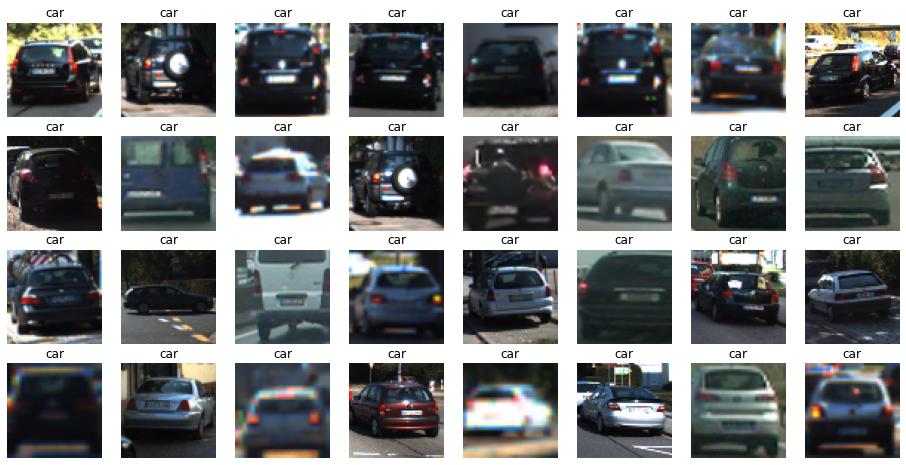

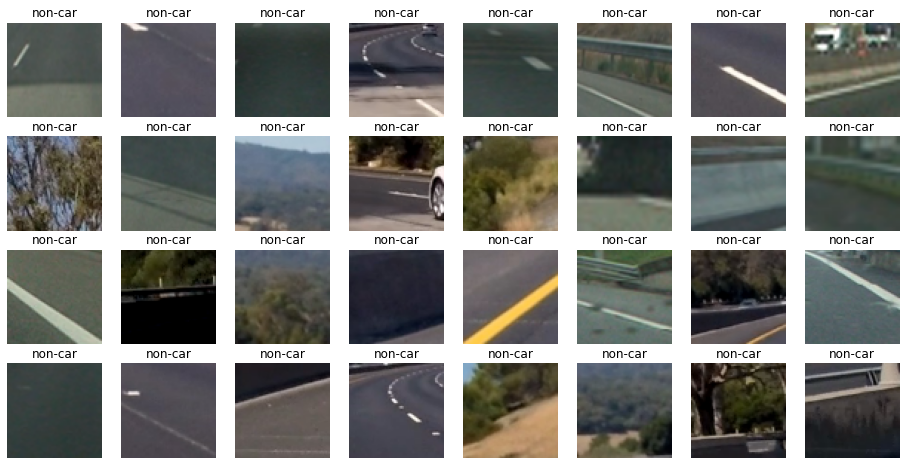

In [28]:
# for car
figure, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))
axes = axes.flatten()

for i in range(32):
    rand_i = np.random.randint(0, len(car_paths))
    image = mpimg.imread(car_paths[rand_i])
    axes[i].axis('off')
    axes[i].imshow(image)
    axes[i].set_title('car')

# for non-car
figure, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))
axes = axes.flatten()
for i in range(32):
    rand_i = np.random.randint(0, len(noncar_paths))
    image = mpimg.imread(noncar_paths[rand_i])
    axes[i].axis('off')
    axes[i].imshow(image)
    axes[i].set_title('non-car')

## Feature Extraction

In [7]:
# Color and Shape : Raw pixel(resize)
# Color only : Histogram of pixel value
# Shape only : Hisogram of oriened gradients (HOG)

In [29]:
# (1) Color and Shape : Raw pixel(resize)
def resized_raw_pixel(img, size=(32, 32)):
    # todo : resize된 이미지를 flatten해서 return
    resized_feature = cv2.resize(img, size).ravel() # ravel() or flatten()
    return resized_feature


In [40]:
# (2) Color only : Histogram of pixel value
def color_histogram(img, nbins=32, bins_range=(0, 256)):
    # todo : 채널별 히스토그램을 concatenate 해서 return
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

In [41]:
# (3) Shape only : Hisogram of oriened gradients (HOG)
def get_hog_feature(img_channel, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), feature_vector=True):
    # todo : 입력받은 채널에 대해 HOG feature_vector return
    hog_features = hog(img_channel, orientations=orientations,
                      pixels_per_cell = pixels_per_cell,
                      cells_per_block = cells_per_block,
                      block_norm='L2-Hys', transform_sqrt=False,
                      feature_vector=True)
    return hog_features


In [45]:
def extract_features(file_paths, orientations, pixels_per_cell, cells_per_block,
                     feature_vector, spatial_size, hist_bins, hist_range):
    
    features = []
    for file_path in file_paths: # for car : 8792, for non-car : 8968
        image = mpimg.imread(file_path)
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        
    
        # 1. Hog Feature
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_feature = get_hog_feature(feature_image[:, :, channel], orientations,
                           pixels_per_cell, cells_per_block, feature_vector)
            hog_features.append(hog_feature)
        hog_features = np.ravel(hog_features)

        # 2. Resize Feature
        resized_features = resized_raw_pixel(feature_image, size=spatial_size)

        # 3. Color Histogram
        hist_features = color_histogram(feature_image, hist_bins, hist_range)

        # 1+2+3
        feature = np.concatenate((resized_features, hist_features, hog_features))
        features.append(feature)
    return features        

In [46]:
# hog parameters
orientations = 9 
pixels_per_cell = (8, 8) 
cells_per_block = (2, 2) 
feature_vector=True

# resize parameters
spatial_size = (32, 32) 

# histogram parameters
hist_bins = 32 
hist_range = (0, 256)

In [47]:
car_features = extract_features(car_paths, orientations, pixels_per_cell, cells_per_block,
                feature_vector, spatial_size, hist_bins, hist_range)
noncar_features = extract_features(noncar_paths, orientations, pixels_per_cell, cells_per_block,
                feature_vector, spatial_size, hist_bins, hist_range)

## Data Preparation 

In [48]:
print(len(car_features), len(noncar_features))
print(car_features[0].shape, noncar_features[0].shape)

8792 8968
(8460,) (8460,)


In [50]:
# feature vector 17760(샘플수) x 8460(특성)
X = np.vstack((car_features, noncar_features))
# car or not (1 or 0)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

In [51]:
X.shape, y.shape

((17760, 8460), (17760,))

In [52]:
## 표준화 StandardScaler() : 평균 0, 분산 1의 결과 데이터

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [53]:
## 훈련세트와 테스트 세트 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(14208, 8460) (14208,)
(3552, 8460) (3552,)


## Classifier

In [54]:
# LinearSVC() 
# 모델 훈련
svc_clf = LinearSVC()
svc_clf.fit(X_train, y_train)

LinearSVC()

In [55]:
# 예측
predict = svc_clf.predict(X_test)

In [57]:
predict

array([0., 0., 0., ..., 1., 1., 0.])

In [59]:
# 성능측정
(predict == y_test).sum()/len(y_test)

0.9893018018018018

## Saving Model

In [60]:
data_pickle = {}
data_pickle['svc_clf'] = svc_clf
data_pickle['scaler'] = scaler


fd = open('svc_pickle.p', 'wb')
pickle.dump(data_pickle, fd)